## Summary of the notebook
* [Built a function for selection of features in a greedy manner](#greedy_feature_selection)
* [Boruta_Py : Another way of selecting features](#boruta_py_feature_selection)
* [Permutation_Importance : A method for feature selection](#permutation_importance_feature_selection)

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
import gc
import lightgbm as lgb
import eli5
from eli5.sklearn import PermutationImportance

c:\users\capiot\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\users\capiot\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1. Data Preparation Stage

In [ ]:
##Let's store some important stuff

## Storing all the imputed feature names
pickle.dump(all_cols,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/all_cols.pkl','wb'))
pickle.dump(dt_imputed_cols,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/dt_imputed_cols.pkl','wb'))
pickle.dump(nnull_cols,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/nnull_cols.pkl','wb'))

## Storing boruta important features selected in first iteration
pickle.dump(boruta_imp_feat,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/boruta_imp_feat.pkl','wb'))
pickle.dump(feature_set_2.columns,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/feature_set_2_cols.pkl','wb'))
pickle.dump(feature_set_3.columns,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/feature_set_3_cols.pkl','wb'))

## Storing all features,y_target and outlier column 
## used for feature selection process
pickle.dump(X_train,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/X_train_feat_imp.pkl','wb'))
pickle.dump(y_target,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/y_target_feat_imp.pkl','wb'))
pickle.dump(y_outliers,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/y_outliers_feat_imp.pkl','wb'))

## Storing all of the train data
pickle.dump(train_data,open('gdrive/My Drive/ColabNotebooks/feature_importance_files/train_data_with_all_feat.pkl','wb'))

In [ ]:
## Important stuff to read
## Storing all the imputed feature names
all_cols = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/all_cols.pkl','rb'))
dt_imputed_cols = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/dt_imputed_cols.pkl','rb'))
nnull_cols = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/nnull_cols.pkl','rb'))

## Storing boruta important features selected in first iteration
boruta_imp_feat = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/boruta_imp_feat.pkl','rb'))
feature_set_2_cols = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/feature_set_2_cols.pkl','rb'))
feature_set_3_cols = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/feature_set_3_cols.pkl','rb'))

## Storing all features,y_target and outlier column 
## used for feature selection process
X_train = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/X_train_feat_imp.pkl','rb'))
y_target = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/y_target_feat_imp.pkl','rb'))
y_outliers = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/y_outliers_feat_imp.pkl','rb'))

## Storing all of the train data
train_data = pickle.load(open('gdrive/My Drive/ColabNotebooks/feature_importance_files/train_data_with_all_feat.pkl','rb'))

<a id = 'greedy_feature_selection'></a>
## 2. Greedy way of Forward Feature Selection

In [ ]:
def calc_rmse(model,x,y_true):
  y_pred = model.predict(x)
  return np.sqrt(mse(y_true,y_pred))

In [ ]:
def checkRMSE(X_train,y_train,train_cols,cv):
  
  """
  This function calculates rmse values for the training data
  with the mentioned cross-validation number.
  It returns average rmse calculated over each fold.
  """

  ## performing Stratified K-fold
  stratKfolds = StratifiedKFold(n_splits = cv)
  ## we are splitting by outlier data because we want equal percentages of outliers in both train and validation data
  lgbm = lgb.LGBMRegressor()
  min_rmse = 100
  best_fold = 0
  avg_rmse = 0

  for (fold,(train_index,val_index)) in enumerate(stratKfolds.split(X_train,X_train['outliers'])):
      
      X_trans_train = X_train.iloc[train_index][train_cols]
      y_trans_train = y_train.iloc[train_index]

      X_trans_val = X_train.iloc[val_index][train_cols]
      y_trans_val = y_train.iloc[val_index]

      
      lgbm.fit(X_trans_train,y_trans_train)
      y_pred = lgbm.predict(X_trans_val)
      rmse = calc_rmse(lgbm,X_trans_val,y_trans_val)
      avg_rmse = avg_rmse + rmse
  return avg_rmse/cv

In [ ]:
selected_features = X_train.columns
print("Length of selected features : ",len(selected_features))

Length of selected features :  191


In [ ]:
## A Greedy way of selecting features using forward feature selection
## Here we go in a linear fashion and add columns to the feature set 
## based on whether they improve the rmse score or not

## and calculate rmse for that

min_rmse = 100
init_cols = []
no_of_feat_passed = 0
for col in selected_features:
  new_cols = init_cols + [col]
  rmse = checkRMSE(X_train,y_target,new_cols,3)
  if min_rmse > rmse:
    init_cols = new_cols
    min_rmse = rmse
    print("New rmse : ",min_rmse)
    print("Number of features passed : ",no_of_feat_passed)
  no_of_feat_passed += 1


New rmse :  3.8482126393947116
Number of features passed :  0
New rmse :  3.8444470462245603
Number of features passed :  1
New rmse :  3.8430494014222325
Number of features passed :  2
New rmse :  3.838739249757834
Number of features passed :  3
New rmse :  3.824572897406623
Number of features passed :  4
New rmse :  3.790084927827376
Number of features passed :  5
New rmse :  3.7845615236569685
Number of features passed :  7
New rmse :  3.784374605214659
Number of features passed :  11
New rmse :  3.7842564653067714
Number of features passed :  12
New rmse :  3.782575706974963
Number of features passed :  17
New rmse :  3.7752342074625163
Number of features passed :  22
New rmse :  3.773427259351633
Number of features passed :  23
New rmse :  3.7731498346934913
Number of features passed :  33
New rmse :  3.772299465743258
Number of features passed :  34
New rmse :  3.7717779954643795
Number of features passed :  144
New rmse :  3.771755481456504
Number of features passed :  156
New r

<a id="boruta_py_feature_selection"></a>
## 3. Boruta Py Feature Selection

In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import numpy as np

###initialize Boruta
rfRegressor = RandomForestRegressor(
   n_jobs = -1,
   max_depth = 5,
   max_features = 'sqrt',
   verbose=20
)
boruta = BorutaPy(
   estimator = rfRegressor, 
   n_estimators = 100,
   max_iter = 100,# number of trials to perform
   verbose = 20
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X_train), np.array(y_target['target']))

In [ ]:
### print results
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

features in the green area: ['first_active_year', 'category_1_nunique', 'month_mode', 'month_nunique', 'year_min', 'year_nunique', 'installments_mode', 'installments_min', 'avg_sales_lag3_sum', 'merch_cat_svd_0', 'merch_cat_svd_3', 'merch_cat_svd_6', 'merch_cat_svd_8', 'merch_cat_svd_16', 'np_amount_min_0_3_avg', 'install_1_min', 'np_amount_std_3_5', 'install_2_min', 'wday_count', 'month_count', 'is_purchase_month_end_count', 'is_purchase_quarter_start_count', 'is_purchase_quarter_end_count', 'is_purchase_year_start_count', 'avg_purchases_lag12_min', 'avg_purchases_lag3_sum', 'np_amount_sum_0_2', 'install_3_min', 'install_3_max', 'pamount_refmonth_ratio_mean', 'pamount_refmonth_ratio_sum', 'pamount_refmonth_ratio_var', 'pamount_refmonth_ratio_min', 'pamount_refmonth_ratio_max', 'pamount_refmonth_ratio_skew', 'purch_days_diff', 'number_of_trans', 'purchase_amount_sum']
features in the blue area: ['np_amount_max_2_4', 'np_amount_sum_2_4', 'np_amount_mean_4_6', 'np_amount_sum_6_8']


In [ ]:
selected_features = green_area + blue_area
pickle.dump(selected_features,open('gdrive/My Drive/ColabNotebooks/boruta_imp_feat.pkl','wb'))

<a id='permutation_importance_feature_selection'></a>
## 4. Permutation Importance

### Making all the necessary imports and prepare the data for feature selection

In [ ]:
strat_kfold = StratifiedKFold(n_splits = 3)
X_train_cols = X_train.columns
y_train_cols = y_target.columns

imp_feat_fold_wise = []
feat_imp = pd.DataFrame(index=X_train_cols)

for (fold,(trn_index,val_index)) in enumerate(strat_kfold.split(X_train,y_outliers)):
    
    print("************************************")
    print("Creating Fold : ",fold)
    print("Creating Train and Validation Set...")
    X_trn,y_trn = X_train.iloc[trn_index],y_target.iloc[trn_index] 
    X_val,y_val = X_train.iloc[val_index],y_target.iloc[val_index]
    
    
    print("Size of Train Data : ",len(trn_index))
    print("Size of Validation Data : ",len(val_index))

    print("Creating LGBM Regressor...")
    lgbm_regressor = lgb.LGBMRegressor(silent=False)
    print("Fitting on LGBM Regressor...")
    lgbm_regressor.fit(X_trn,y_trn,verbose=20)
    
    print("Performing Permutation Importance...")
    perm = PermutationImportance(lgbm_regressor).fit(X_val,y_val)
    print("Adding feature importance and standard deviation...")
    feat_imp['feat_imp_' + str(fold)] = perm.feature_importances_
    feat_imp['feat_std_' + str(fold)] = perm.feature_importances_std_

    
    sorted_feat_imp = feat_imp.sort_values(by='feat_imp_'+str(fold),axis=0,ascending=False)
    imp_feat = set(sorted_feat_imp[sorted_feat_imp['feat_imp_'+str(fold)] > 0].index.values)
    imp_feat_fold_wise.append(imp_feat)
    temp_train = pd.concat([X_train,y_outliers],axis=1)
    print("Avg RMSE : ",checkRMSE(temp_train,y_target,imp_feat,3))
    #print(perm.results_)

In [ ]:
temp_train = pd.concat([X_train,y_outliers],axis=1)
print("Avg RMSE : ",checkRMSE(temp_train,y_target,imp_feat,3))
print("Number of non zero feature importance features : ",len(imp_feat))

Avg RMSE :  3.7672837884685175
Number of non zero feature importance features :  120


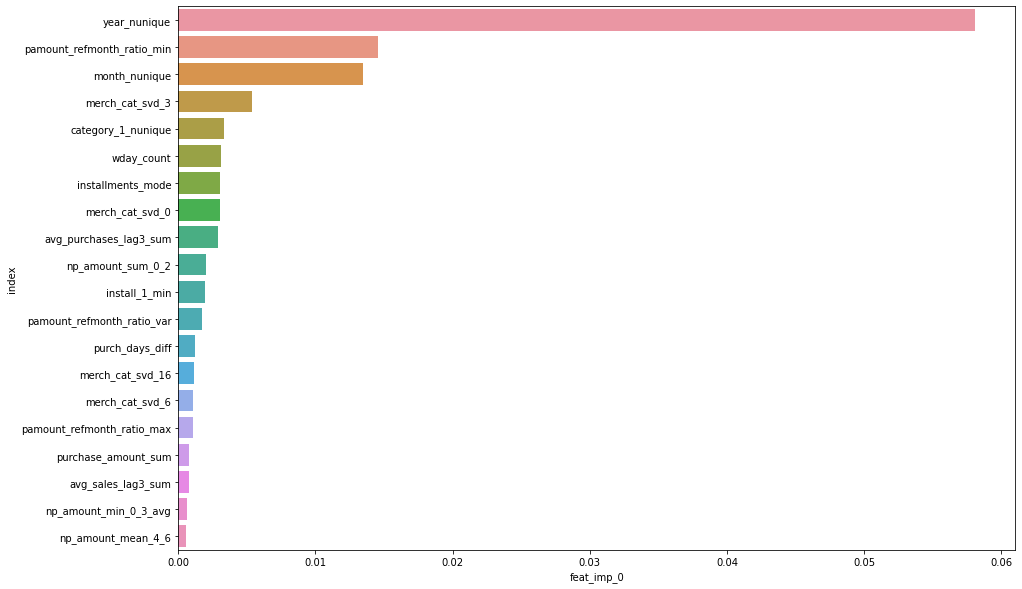

In [ ]:
import seaborn as sns
fig,ax = plt.subplots(figsize=(15,10))
sns.barplot('feat_imp_0','index',data = sorted_feat_imp.iloc[:20],orient='h',ax=ax)

In [2]:
trans_new_df = pickle.load(open('trans_new_df.pkl','rb'))
trans_new_df.head()

,card_id,category_1_mode,category_1_nunique,category_2_mode,category_2_nunique,category_3_mode,category_3_nunique,city_id_mode,city_id_nunique,state_id_mode,...,is_childrens_day_count,is_childrens_day_nunique,is_valentines_day_mode,is_valentines_day_min,is_valentines_day_count,is_valentines_day_nunique,is_fathers_day_mode,is_fathers_day_min,is_fathers_day_count,is_fathers_day_nunique
0,C_ID_ef55cf8d4b,N,2,1.0,1,B,2,69,3,9,...,22,1,False,False,22,1,False,False,22,1
1,C_ID_241a01e9d9,N,1,1.0,1,C,1,69,2,9,...,2,1,False,False,2,1,False,False,2,1
2,C_ID_a97720321f,N,1,1.0,2,A,1,69,2,9,...,12,1,False,False,12,1,False,False,12,1
3,C_ID_8c9ba46f19,N,1,4.0,3,A,1,17,4,22,...,29,1,False,False,29,1,False,False,29,1
4,C_ID_7e64479fbb,N,1,5.0,3,A,1,223,4,21,...,16,1,False,False,16,1,False,False,16,1


In [3]:
null_count_df = ((trans_new_df.isnull().sum()*100)/(trans_new_df.shape[0])).reset_index().rename(columns = {0:'count'})
null_count_df.head()

,index,count
0,card_id,0.000000
1,category_1_mode,0.000000
2,category_1_nunique,0.000000
3,category_2_mode,3.129132
4,category_2_nunique,0.000000


In [16]:
null_counts = np.percentile(null_count_df['count'].values,q=[0,25,50,75,90,95,99])
null_counts

array([  0.        ,   0.        ,   0.        ,  52.04571467,
        99.45495761,  99.97597035, 100.        ])

Text(0, 0.5, 'Percentage of missing values')

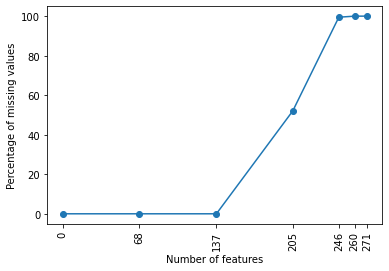

In [17]:
x_ticks = [int(i*(274/100)) for i in [0,25,50,75,90,95,99]]
plt.xticks(x_ticks,x_ticks,rotation=90)
plt.plot(x_ticks,null_counts,marker='o')
plt.xlabel("Number of features")
plt.ylabel("Percentage of missing values")

Dropping features beyond 25%ile missing value mark.

In [18]:
selected_cols_for_impute = null_count_df[null_count_df['count'] <= 52]['index'].values

In [20]:
pickle.dump(selected_cols_for_impute,open('selected_cols_from_new_trans.pkl','wb'))